# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    all_data = []

    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)
        if not os.path.isdir(subject_path):
            continue

        for session in ['Midterm 1', 'Midterm 2', 'Final']:
            session_path = os.path.join(subject_path, session)
            if not os.path.exists(session_path):
                continue

            try:
                # heart rate data
                with open(os.path.join(session_path, 'HR.csv'), 'r') as f:
                    hr_start = float(f.readline()) # starting timestamp
                    hr_freq = float(f.readline()) # sampling freq
                    hr_data = [float(line.strip()) for line in f]
                    hr_time = pd.to_datetime(np.arange(len(hr_data)) / hr_freq + hr_start, unit='s', utc=True)
                    df_hr = pd.DataFrame({'timestamp': hr_time, 'heart_rate': hr_data})

                # EDA data
                with open(os.path.join(session_path, 'EDA.csv'), 'r') as f:
                    eda_start = float(f.readline()) # starting timestamp
                    eda_freq = float(f.readline()) # sampling freq
                    eda_data = [float(line.strip()) for line in f]
                    eda_time = pd.to_datetime(np.arange(len(eda_data)) / eda_freq + eda_start, unit='s', utc=True)
                    df_eda = pd.DataFrame({'timestamp': eda_time, 'eda': eda_data})

                # temperature data
                with open(os.path.join(session_path, 'TEMP.csv'), 'r') as f:
                    temp_start = float(f.readline()) # starting timestamp
                    temp_freq = float(f.readline()) # sampling freq
                    temp_data = [float(line.strip()) for line in f]
                    temp_time = pd.to_datetime(np.arange(len(temp_data)) / temp_freq + temp_start, unit='s', utc=True)
                    df_temp = pd.DataFrame({'timestamp': temp_time, 'temperature': temp_data})

                # merge all dataframes on timestamp
                df = df_hr.merge(df_eda, on='timestamp', how='outer')
                df = df.merge(df_temp, on='timestamp', how='outer')
                df['subject_id'] = subject  
                df['session'] = session
                all_data.append(df)

            except FileNotFoundError:
                print(f"Missing file(s) in {session_path}")

    # combine dataframes
    df_all = pd.concat(all_data, ignore_index=True)
    return df_all

In [18]:
raw_data = load_data('data/raw')
raw_data

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-10-13 12:55:21+00:00,NaN,0.000000,22.23,S5,Midterm 1
1,2018-10-13 12:55:21.250000+00:00,NaN,0.002562,22.23,S5,Midterm 1
2,2018-10-13 12:55:21.500000+00:00,NaN,0.021779,22.23,S5,Midterm 1
3,2018-10-13 12:55:21.750000+00:00,NaN,0.021779,22.23,S5,Midterm 1
4,2018-10-13 12:55:22+00:00,NaN,0.019217,22.23,S5,Midterm 1
...,...,...,...,...,...,...
1773140,2018-12-05 20:25:52.250000+00:00,NaN,0.011532,23.21,S9,Final
1773141,2018-12-05 20:25:52.500000+00:00,NaN,0.012813,23.21,S9,Final
1773142,2018-12-05 20:25:52.750000+00:00,NaN,0.011532,23.21,S9,Final
1773143,2018-12-05 20:25:53+00:00,123.07,0.011532,NaN,S9,Final


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [ ]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    processed_data = []

    for subject_id, subject_df in data.groupby('subject_id'):
        subject_df = subject_df.sort_values('timestamp')
        subject_df['timestamp'] = pd.to_datetime(subject_df['timestamp'], unit='s')
        subject_df = subject_df.set_index('timestamp')

        # 1. Handle missing values (only on numeric columns)
        numeric_cols = ['heart_rate', 'eda', 'temperature']
        threshold = int(0.01 * len(subject_df))
        
        for col in numeric_cols:
            if col in subject_df.columns:
                if subject_df[col].isna().sum() <= threshold:
                    subject_df[col] = subject_df[col].fillna(subject_df[col].mean())

        # 2. Resample to regular intervals (1 second)
        # get non-numeric columns to preserve
        non_numeric_cols = [col for col in subject_df.columns if col not in numeric_cols and col != 'session']
        
        # store the first value of non-numeric columns per session
        if non_numeric_cols:
            const_cols = subject_df[non_numeric_cols + ['session']].groupby('session').first()
        
        # resample only numeric columns
        resampled = (
            subject_df[numeric_cols + ['session']]
            .groupby('session')
            .apply(lambda x: x.resample('1S').mean().interpolate(method='linear'))
        )
        
        # merge back with non-other columns
        if non_numeric_cols:
            resampled = resampled.join(const_cols, on='session', how='left')
        
        resampled = resampled.reset_index()
        resampled['subject_id'] = subject_id

        # 3. Remove outliers (z-score > 3)
        for col in numeric_cols:
            if col in resampled.columns:
                z = np.abs(stats.zscore(resampled[col].fillna(0)))
                resampled.loc[z > 3, col] = np.nan

        # 4. Save processed data to CSV files
        processed_data.append(resampled)
        resampled.to_csv(os.path.join(output_dir, f'{subject_id}_processed.csv'), index=False)
        
    return pd.concat(processed_data, ignore_index=True)

In [24]:
processed_data = preprocess_data(raw_data, output_dir='data/processed')
processed_data

/var/folders/qp/sfr1kq8d0vb22ptlgqtw64bc0000gn/T/ipykernel_60354/1517943477.py:47: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .apply(lambda x: x.resample('1S').mean().interpolate(method='linear'))
/var/folders/qp/sfr1kq8d0vb22ptlgqtw64bc0000gn/T/ipykernel_60354/1517943477.py:47: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .apply(lambda x: x.resample('1S').mean().interpolate(method='linear'))
/var/folders/qp/sfr1kq8d0vb22ptlgqtw64bc0000gn/T/ipykernel_60354/1517943477.py:47: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .apply(lambda x: x.resample('1S').mean().interpolate(method='linear'))
/var/folders/qp/sfr1kq8d0vb22ptlgqtw64bc0000gn/T/ipykernel_60354/1517943477.py:47: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .apply(lambda x: x.resample('1S').mean().interpolate(me

,session,timestamp,heart_rate,eda,temperature,subject_id
0,Final,2018-12-05 16:28:57+00:00,NaN,0.011852,21.890000,S1
1,Final,2018-12-05 16:28:58+00:00,NaN,0.023064,21.890000,S1
2,Final,2018-12-05 16:28:59+00:00,NaN,0.023704,21.910000,S1
3,Final,2018-12-05 16:29:00+00:00,NaN,0.023384,21.910000,S1
4,Final,2018-12-05 16:29:01+00:00,NaN,0.023704,21.890000,S1
...,...,...,...,...,...,...
443297,Midterm 2,2018-11-10 17:44:42+00:00,159.47,0.015055,22.970000,S9
443298,Midterm 2,2018-11-10 17:44:43+00:00,158.68,0.014735,22.970000,S9
443299,Midterm 2,2018-11-10 17:44:44+00:00,157.72,0.014735,22.970000,S9
443300,Midterm 2,2018-11-10 17:44:45+00:00,156.45,0.014735,28.443362,S9


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [39]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    df = data[(data['subject_id'] == subject_id) & (data['session'] == session)]
    if df.empty:
        raise ValueError(f"No data found for subject {subject_id}, session {session}")
    
    # 1. Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # 2. Plot each physiological signal
    # +
    # 3. Add labels and titles
    signals = ['heart_rate', 'eda', 'temperature']
    for ax, signal in zip(axs, signals):
        ax.plot(df['timestamp'], df[signal], label=signal)
        ax.set_ylabel(signal.replace('_', ' ').title())
        ax.grid(True)
        ax.legend(loc='upper right')

    fig.suptitle(f"Physiological Signals for {subject_id} ({session})")
    axs[-1].set_xlabel("Timestamp")

    # 4. Save plot to file
    plt.tight_layout()
    filename = f"S{subject_id}_{session.replace(' ', '_')}_signals.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)

    return fig

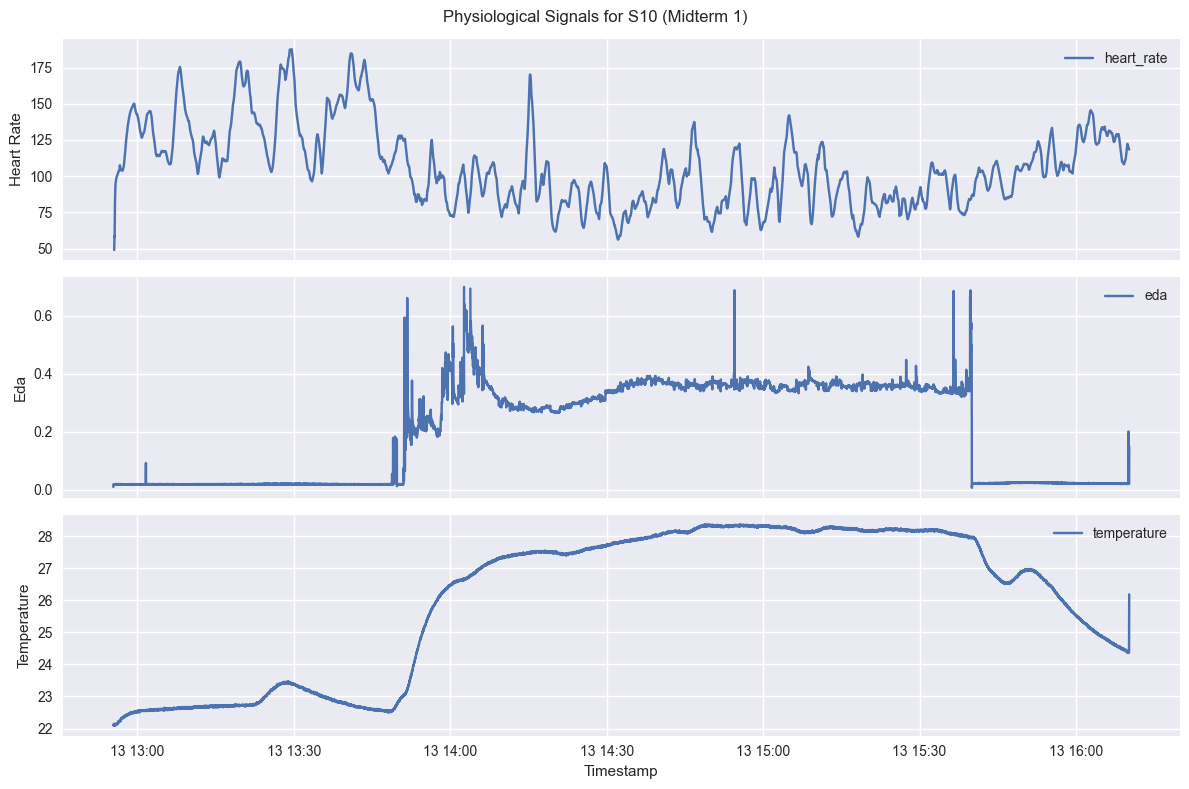

In [47]:
fig = plot_physiological_signals(processed_data, subject_id='S10', session='Midterm 1', output_dir='plots')